In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import skimage
import os
import scipy.misc
from skimage import data
from scipy import ndimage
from skimage.color import rgb2gray, gray2rgb, rgb2hsv
import os
import numpy as np
import bokeh
from bokeh.io import output_notebook, curdoc
from bokeh.plotting import ColumnDataSource
from bokeh.plotting import figure, output_file, show
from bokeh.palettes import d3
import bokeh.models as bmo
import pandas as pd
import win32api
import scipy.special
import seaborn as sns

In [2]:
GLOBAL_WIDTH = 800
GLOBAL_HEIGHT = 600
output_notebook()
pd.set_option('mode.chained_assignment', None)
plt.rcParams["figure.figsize"] = (10,10)

Loading BokehJS ...

# Preliminary Cleaning of Dataset

In the original code for scrapping from the website, we must consider the missing data from our dataset for each column

In [3]:
df = pd.read_csv('metadata.csv')

In [4]:
print('Columns with missing values')
print(df.isnull().any(axis=0))
print('Number of missing values from each column')
print(df.isnull().sum())
print('Percentage of missing values from each column')
print(df.isnull().sum() * 100 / len(df))

Columns with missing values
Image Link     False
Dimensions      True
Shape          False
Date            True
Title           True
Artist         False
Object Type    False
dtype: bool
Number of missing values from each column
Image Link       0
Dimensions     257
Shape            0
Date            21
Title            1
Artist           0
Object Type      0
dtype: int64
Percentage of missing values from each column
Image Link      0.000000
Dimensions     18.124118
Shape           0.000000
Date            1.480959
Title           0.070522
Artist          0.000000
Object Type     0.000000
dtype: float64


### Date

- For the Date column, it will be used for sorting our images by object type and by year so when we download and sort images we run the dates through the 'date_process' function which extracts the year of a painting from string type data while giving the value 'Date Missing' to rows with missing dates. 

- We can see that we are not losing much data when omitting the missing date images so I believe it is better to remove it as without dates it seems pointless to include certain artwork in doing analysis of the evolution of Mondrian's style

### Title

- For the Title column, we are missing one value but when we download images we save the image under 'No Title' as the title is not essential for analysis of style so we do not drop it

### Dimensions

- We are missing a large amount of data on dimensions however with regards to quality of the data we do not care for the actual dimensions of the picture instead we care about the digital resolution so we disregard this column

In [11]:
def grab_stats(image):
    try:
        if len(image.shape) == 2:
            image = gray2rgb(image)
        hsv_img = rgb2hsv(image)
        saturation_img = hsv_img[:,:, 1]
        value_img = hsv_img[:, :, 2]
        hue_img = hsv_img[:, :, 0]
        pixelcount = image.shape[0] * image.shape[1]
        mean_saturation = np.mean(saturation_img, axis=(0,1))
        mean_brightness = np.mean(value_img)
        mean_hue = np.mean(hue_img, axis=(0,1))
        per_row_var = np.var(value_img, axis=1)
        per_row_avg = np.mean(per_row_var)
        resolution = '{0} x {1}'.format(image.shape[0], image.shape[1])
        unique_colors = np.unique(image.reshape(-1, image.shape[-1]), axis=0).shape[0]
        return mean_saturation, mean_brightness, per_row_var, per_row_avg, pixelcount, resolution, mean_hue, unique_colors
    except ValueError:
        return None
    
def edge_score_calculate(img):
    if len(img.shape) == 2:
        img = gray2rgb(img)
    hsv_img = rgb2hsv(img)
    value_img = hsv_img[:, :, 2]
    
    sobel_x = ndimage.sobel(value_img, axis=0, mode='constant')
    sobel_y = ndimage.sobel(value_img, axis=1, mode='constant')
    edge_image = np.hypot(sobel_x, sobel_y)
    edge_score = np.sum(edge_image)
    return edge_score

    

### Choosing the object types to analyze

In [8]:
df['Object Type'].unique()

array(['drawing', 'painting', 'book', 'watercolor (painting)',
       'oil sketch', 'print', 'ethnographic',
       'pulpit, decorative wall component', 'ceiling painting', 'collage',
       'graphic design (guide term)', 'postcard', 'unknown', 'triptych',
       'scale-model', 'sketchbook, drawing', 'case furniture', 'chair',
       'table', 'terracotta'], dtype=object)

For the paintings, the categories under it would be:

- ceiling painting
- oil sketch
- painting
- print
- triptych
- watercolor (painting)

For drawings, the categories under it would be:

- drawing
- ethnographic
- graphic design (guide term)
- sketchbook, drawing

In [12]:
painting_categories = ['ceiling painting', 'oil sketch', 'painting', 'print', 'triptych', 'watercolor (painting)']
drawing_categories = ['drawing', 'ethnographic', 'graphic design (guide term)', 'sketchbook, drawing']

Here we get the statistics we want to display such as resolution or saturation

In [13]:
df_image_stats = pd.DataFrame(columns=['Mean Saturation', 'Mean Brightness','Mean Hue', 'Edge Score', 'Per Row Average Variance', 'Pixel Count','Image Directory','Date','Description', 'Resolution', 'Category','Object Type','Color Complexity'])

main_dir = 'images'
for obj_type in os.listdir(main_dir):
    if (obj_type in painting_categories) or (obj_type in drawing_categories):
        for year in os.listdir(main_dir+'\\'+obj_type):
            files = os.listdir(main_dir+'\\'+obj_type+'\\'+year)
            for file in files:
                directory_file =(main_dir+'\\'+obj_type+'\\'+year+'\\'+file)
                img = io.imread(directory_file)
                stats = grab_stats(img)
                if not stats==None:
                    if obj_type in painting_categories:
                        category = 'Painting'
                    else:
                        category = 'Drawing'
                    edge_score = edge_score_calculate(img)
                    directory = main_dir+'\\'+obj_type+'\\'+year+'\\'+file
                    description = 'Name : {0}, Year : {1}, Object Type: {2}'.format(file,year,obj_type)
                    df_image_stats = df_image_stats.append({'Mean Saturation':stats[0], 'Mean Brightness':stats[1], 'Mean Hue':stats[6], 'Edge Score':edge_score, 'Per Row Average Variance':stats[3], 'Pixel Count':stats[4],'Resolution':stats[5],
                                                            'Image Directory':directory,'Date':year,'Description':description,'Category':category,'Object Type':obj_type,'Color Complexity':stats[7]}, ignore_index = True)
            

Here I remove the entries with missing dates

In [93]:
df_image_stats = df_image_stats[df_image_stats['Date']!='Date Missing']
df_image_stats['Date'] = df_image_stats['Date'].astype(int)

In [76]:
pixelcount_table = df_image_stats['Pixel Count'].values

In [77]:
curdoc().theme = 'dark_minimal'

def make_plot(title, hist, edges):
    p = figure(title=title, tools='', width=GLOBAL_WIDTH, height=GLOBAL_HEIGHT)
    p.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:],
           fill_color="navy", alpha=0.5)
    p.y_range.start = 0
    p.xaxis.axis_label = 'x'
    p.yaxis.axis_label = 'Pr(x)'
    p.grid.grid_line_color="white"
    return p

hist, edges = np.histogram(pixelcount_table, density=True, bins=100)

p = make_plot("Resolution", hist, edges)
output_file('Resolution Distribution.html')
show(p)

In [78]:
print("Mean :{0}".format(np.mean(pixelcount_table)))
print("Median :{0}".format(np.median(pixelcount_table)))
print("Standard Deviation :{0}".format(np.std(pixelcount_table)))
print("Max :{0}".format(np.max(pixelcount_table)))
print("Min :{0}".format(np.min(pixelcount_table)))

Mean :321238.1050041017
Median :317850.0
Standard Deviation :50211.8003603194
Max :422500
Min :150800


### Resolution threshold

After visual examination of some images below the 200,000 pixelcount threshold it showed signs of image blurring due to low resolution resulting in loss of detail so that would be our resolution threshold 

With this threshold, we lose about 1.06% of our dataset which I believe is a fair trade-off so that our research is not muddled by low resolution images

In [79]:
df_image_stats[df_image_stats['Pixel Count']<=200000].shape[0]*100 / df_image_stats.shape[0]

1.066447908121411

In [94]:
df_image_stats_resolution_cutoff = df_image_stats[df_image_stats['Pixel Count']>200000]

### Grayscale vs RGB

For images that are grayscale we can just add a new column to our dataframe of image information by checking if the shape of the image has 1 or 3 channels.  
As we can see for the example I have chosen of a colored image, when it is read in the shape indicates the number of rows and columns of pixels then the array of length 3 represents the three color channels RGB  
while the grayscale image I have chosen when read in only contains one value to represent each pixel instead of an array indicating it is a grayscale image

In [81]:
colored_mondrian_painting = io.imread('images/drawing/1905/Study for the Winkel mill.jpeg')
grayscale_mondrian_painting = io.imread('images/drawing/1905/Fen near Saasveld.jpeg')

In [82]:
print(colored_mondrian_painting.shape)
print(grayscale_mondrian_painting.shape)

(650, 431, 3)
(434, 650)


For our study of Mondrian's work we will be omitting about 1% of his work due to low resolution while retaining both Grayscale and RGB images as we research hue and saturation which require color but grayscale images of Mondrian's work can also  
be applied to these explorations as they indicate a lack of color in his work

As we can see 89.1% of the dataset is RGB however losing 10.9% of our dataset does not seem wise in our evaluation of Mondrian due to the limited dataset

In [83]:
df_image_stats_resolution_cutoff['RGB or Grayscale'] =  df_image_stats_resolution_cutoff['Image Directory'].apply(lambda x: len(io.imread(x).shape) == 3)

df_image_stats_resolution_cutoff['RGB or Grayscale'].sum()/df_image_stats_resolution_cutoff.shape[0]

# EDA

In [85]:
numerical_col = ['Mean Saturation','Mean Brightness','Mean Hue','Edge Score','Per Row Average Variance','Color Complexity']

In [86]:
categorical_col = ['Date','Category','RGB or Grayscale']

- For the first part of EDA, I examined the distributions of  certain categories such as Year, Painting/Drawing and RGB/Grayscale.

- Most of Mondrian's work found is dated around 1900 while there are fewer of his newer works which may explain some of the skews in the rest of our EDA.

- We also see that we have more painting than drawings from our Mondrian art dataset and that most of the work is in RGB format

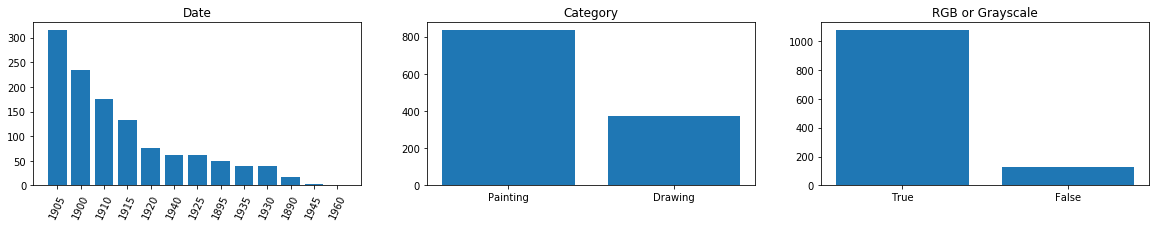

In [87]:
fig, axes = plt.subplots(nrows=1, ncols=len(categorical_col), figsize=(20, 3))

graph_no = 0
axes[0].tick_params('x',labelrotation=65)
for i in categorical_col:
    axes[graph_no].set_title(i)
    axes[graph_no].bar(x = df_image_stats_resolution_cutoff[i].astype(str).value_counts().index.values, height = df_image_stats_resolution_cutoff[i].value_counts().values)
    graph_no += 1

In [88]:
numerical_df = df_image_stats_resolution_cutoff[numerical_col]
numerical_df['Color Complexity'] = numerical_df['Color Complexity'].apply(lambda x : x/(255**3))

max_edgescore = max(numerical_df['Edge Score'])
numerical_df['Edge Score'] =  numerical_df['Edge Score'].apply(lambda x : x/max_edgescore)

max_var = max(numerical_df['Per Row Average Variance'])
numerical_df['Per Row Average Variance'] =  numerical_df['Per Row Average Variance'].apply(lambda x : x/max_var)

Here we graph together the numerical variables we acquire from grabbing stats from our images however I do not see many clear relationships between categories.

One category with seemingly many positive relationships is the Color Complexity with other such as mean saturation and hue which is to be expected as with more colors
our image will be more saturated.

However other than this category there are not many strong relationships among other variables

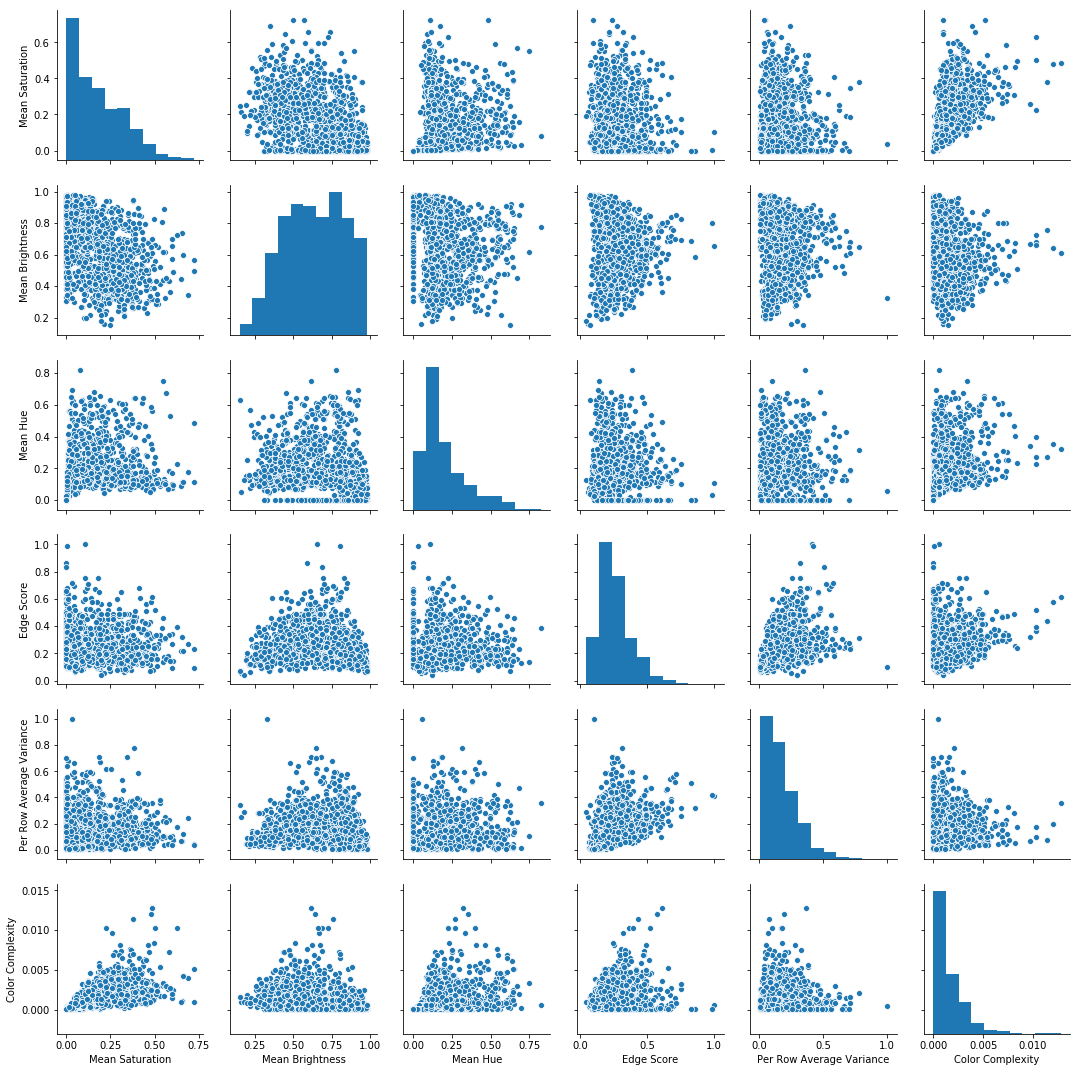

In [89]:
sns.pairplot(numerical_df)

Here we go through the numerical variables with the year the image was dated to.

Immediately we see much more correlation than the previous graphs such as the rise and fall of certain categories.

- For the mean brightness we see over time Mondrian's work gets much brighter which is in accordance with our studies showing his early works being of landscapes taking darker moods while his new works are much more colorful

- We also see the color variance decrease as Mondrian creates more uniform art without much color variance

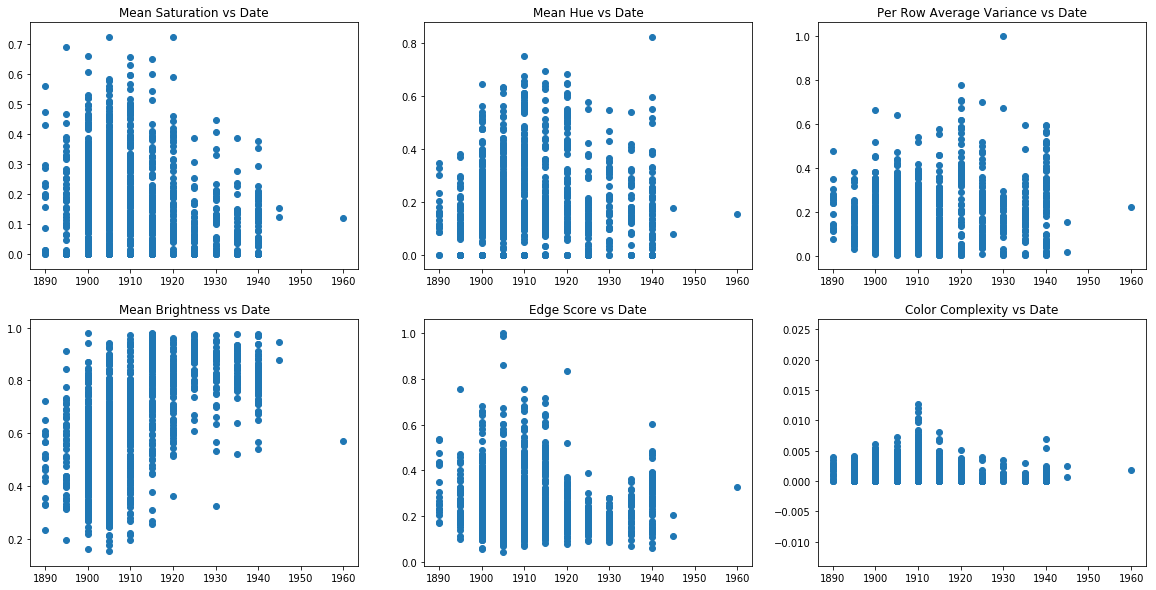

In [119]:
fig, axes = plt.subplots(nrows=2, ncols=len(numerical_col)//2, figsize=(20, 10))

graph_no = 0

for i in range(len(numerical_col)//2):
    for j in range(2):
        axes[j,i].set_title(numerical_col[graph_no]+' vs Date')
        axes[j,i].scatter(x = df_image_stats_resolution_cutoff['Date'].values, y = numerical_df[numerical_col[graph_no]].values)
        graph_no += 1

### PCA Analysis

Unfortunately with our dimensional reduction there is not much clustering to be seen with regards to the year the work was made thus not reflecting noticeable trends with his work

In [105]:
from sklearn.decomposition import PCA
data = numerical_df.values.tolist()
target = df_image_stats_resolution_cutoff['Date'].astype(str).values


pca = PCA(n_components=2)
principalComponents = pca.fit_transform(data)

In [106]:
palette = d3['Category20'][len(set(df_image_stats_resolution_cutoff['Date'].astype(str).values))]
color_map = bmo.CategoricalColorMapper(factors=list(set(df_image_stats_resolution_cutoff['Date'].astype(str).values)),
                                   palette=palette)

In [109]:
source = ColumnDataSource(data=dict(
    x=[i[0] for i in principalComponents],
    y=[i[1] for i in principalComponents],
    years = df_image_stats_resolution_cutoff['Date'].astype(str).values,
    desc=df_image_stats_resolution_cutoff['Description'].values,
    imgs=df_image_stats_resolution_cutoff['Image Directory'].values
))

output_file("pca_graph.html")

TOOLTIPS = """
    <div>
        <div>
            <img
                src="@imgs" height="42" alt="@imgs" width="42"
                style="float: left; margin: 0px 15px 15px 0px;"
                border="2"
            ></img>
        </div>
        <div>
            <span style="font-size: 10px; font-weight: bold;">@desc</span>
        </div>
        <div>
            <span style="font-size: 15px;">Location</span>
            <span style="font-size: 10px; color: #696;">($x, $y)</span>
        </div>
    </div>
"""

p = figure(plot_width=GLOBAL_WIDTH, plot_height=GLOBAL_HEIGHT, tooltips=TOOLTIPS,
           title="PCA Graph",x_axis_label='Principal Component 1',y_axis_label='Principal Component 2')

p.circle('x', 'y', size=10, source=source, color={'field': 'years', 'transform': color_map}, legend_field='years', )
show(p)

### Artnome Mondrian Replication

Above I had already normalized these columns and I calculated the Complexity score based on the article's formula

In [120]:
numerical_df['Complexity Score'] = (numerical_df['Edge Score'] + numerical_df['Per Row Average Variance'] + numerical_df['Color Complexity'])/3

After taking the mean complexity score by year we do not see a gradual decrease in complexity, rather we see a trend of decrease however there are outliers which spike our complexity score such as the small artwork in 1960 causing a massive spike

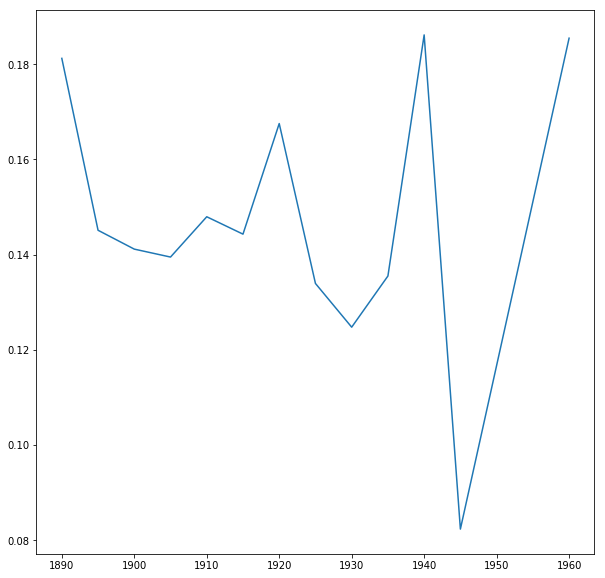

In [125]:
numerical_df['Date'] = df_image_stats_resolution_cutoff['Date']

grouped_df = numerical_df.groupby('Date',as_index=False).mean()[['Complexity Score','Date']]

plt.plot(grouped_df['Date'],grouped_df['Complexity Score'])
plt.show()